In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d] pyvirtualdisplay tqdm

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [5394 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Get:5 http://packages.cloud.google.com/apt cloud-sdk-bionic InRelease [6774 B] 
Get:6 http://packages.cloud.google.com/apt cloud-sdk InRelease [6739 B]        
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Get:8 http://packages.cloud.google.com/apt gcsfuse-bionic/main amd64 Packages [2435 B]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates/restricted amd64 Packages [353 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates/multiverse amd64 Packages [31.4 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [2394 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [2163 kB]
Get:13 http://packages.cloud.goo

In [3]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

In [4]:
%%capture
import gym
env = gym.make('LunarLander-v2')

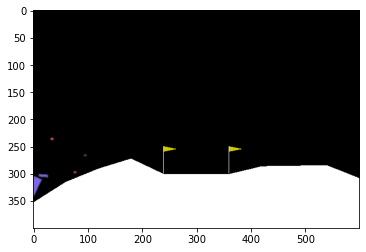

In [5]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [6]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

In [7]:
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

In [8]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

In [9]:
agent.network.train()  # training 模式
EPISODE_PER_BATCH = 5  #  5 個 episodes 更新一次 agent
NUM_BATCH = 400        # 共更新 400 次

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0

        while True:

            action, log_prob = agent.sample(state)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            total_step += 1

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                rewards.append(np.full(total_step, total_reward))  #设定同一个episode每个action的reward都是total reward
                break

    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # reward正则标准化
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

  0%|          | 0/400 [00:00<?, ?it/s]

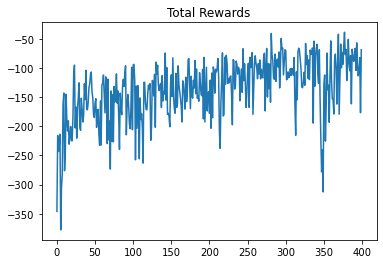

In [10]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

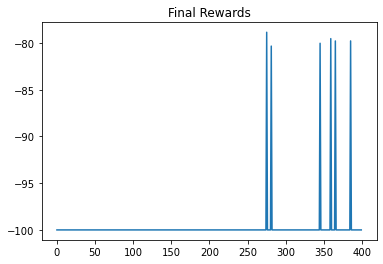

In [11]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()


## **测试**

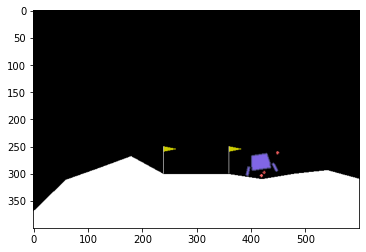

In [12]:
agent.network.eval()  # evaluation 模式

state = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

total_reward = 0

done = False
while not done:
    action, _ = agent.sample(state)
    state, reward, done, _ = env.step(action)

    total_reward += reward

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)